Imports

In [14]:
# Import all the things
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import chart_studio.plotly as py
import plotly.graph_objs as go

pd.options.display.max_rows = 10
pd.options.display.max_seq_items = 200


%matplotlib inline


Data comes from https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/IG0UN2/ELBYL3&version=7.0

Load the data

In [15]:
house_df = pd.read_csv('data/1976-2018-house2.csv', encoding = "ISO-8859-1")

Filter out nonstandard elections and spot check a sample.

In [16]:
filtered_house_df = house_df[
    (house_df.special == False) 
    & (house_df.runoff != True)].copy()
filtered_house_df.runoff=False

filtered_house_df[(filtered_house_df.state=='New York') & (filtered_house_df.district==1) & (filtered_house_df.year==2016)][['year', 'state', 'district', 'party', 'candidate', 'candidatevotes']].head()


,year,state,district,party,candidate,candidatevotes
27603,2016,New York,1,conservative,Lee M. Zeldin,23327
27604,2016,New York,1,women's equality,Anna E. Throne-Holst,2496
27605,2016,New York,1,working families,Anna E. Throne-Holst,6147
27606,2016,New York,1,republican,Lee M. Zeldin,158409
27607,2016,New York,1,NaN,Void Vote,122


Annoyingly, candidates can get votes in the same election from different parties.  We sum them up here.

In [17]:
factors = ['year', 'state', 'district', 'candidate']
house_by_candidate = filtered_house_df[(pd.notna(filtered_house_df.party))].groupby(factors).candidatevotes.sum().reset_index()


Next we take the top two candidates by total votes.  Often, but definitely not always, this is D + R.

In [18]:
top_two = house_by_candidate.groupby(['year', 'state', 'district']).apply(lambda x: x.nlargest(2, 'candidatevotes' )).reset_index(drop=True)


And now we need a best-guess label for the candidate (ex D if they are basically a D that got other votes).  Take the most-vote party by candidate.

In [ ]:
max_vote_party_per_candidate = house_by_candidate.groupby(['year', 'state', 'district', 'candidate']).candidatevotes.max().reset_index()

In [ ]:
best_party_per_candidate = filtered_house_df.merge(max_vote_party_per_candidate, on=['year', 'state', 'district', 'candidate'])[['year', 'state', 'district', 'candidate', 'party']]

partied_top_two = top_two[top_two.year>1990].merge(best_party_per_candidate, on=['year', 'state', 'district', 'candidate'])

In [21]:
# pd.options.display.max_rows = 60
# partied_top_two.groupby(['party']).count().reset_index().sort_values(['year'], ascending=False)
# pd.options.display.max_rows = 10# party_affiliation

Spot checks.

In [22]:
partied_top_two

,year,state,district,candidate,candidatevotes,party
0,1992,Alabama,1,Sonny Callahan,128874,republican
1,1992,Alabama,1,William A. Brewer,78742,democrat
2,1992,Alabama,2,Terry Everett,112906,republican
3,1992,Alabama,2,"George C. Wallace, Jr.",109335,democrat
4,1992,Alabama,3,Glen Browder,119175,democrat
...,...,...,...,...,...,...
12687,2018,Wisconsin,7,Margaret Engebretson,124307,democrat
12688,2018,Wisconsin,8,Mike Gallagher,209410,republican
12689,2018,Wisconsin,8,Beau Liegeois,119265,democrat
12690,2018,Wyoming,0,Liz Cheney,127963,republican


Make the spine of a thing to merge data into

In [ ]:
base = top_two[top_two.year>1990][['year','state','district']].drop_duplicates()

Merge in D and R votes.  Check out Wisconsin and NY; big places are not just D vs R.

top_two_by_race = base.merge(partied_top_two[partied_top_two.party=='republican'], on=['year','state','district'], how='left')
top_two_by_race = top_two_by_race.merge(partied_top_two[partied_top_two.party=='democrat'], on=['year','state','district'], how='left')

Rename some columns.

In [25]:
top_two_by_race.columns = ['year', 'state', 'district', 'republican_candidate', 'republican_votes', 'republican_party', 'democratic_candidate', 'democratic_votes', 'democratic_party']


This was where I exported data to use in the other viz tab that wrote to mapbox.

In [13]:
# top_two_by_race = top_two_by_race.dropna().copy()
# sample = top_two_by_race[top_two_by_race.year>=2002]
# sample['r_edge'] = sample.republican_votes - sample.democratic_votes
# sample.groupby(['state', 'district']).r_edge.mean().reset_index().sort_values('r_edge')
# pd.options.display.max_rows = 300
# sample[abs(sample.r_edge>100000)].sort_values('r_edge', ascending=False).head(1)

# sample.to_csv('~/.interchange/gerrymander_sample.csv')



<ipython-input-13-dd4375a69871>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sample['r_edge'] = sample.republican_votes - sample.democratic_votes


Resources: 
Found [538's work](https://fivethirtyeight.com/tag/the-gerrymandering-project/), which is much better for visualizing potential redistrictings. Found [NYT on PA](https://www.nytimes.com/interactive/2018/02/19/upshot/pennsylvania-new-house-districts-gerrymandering.html).  

Cuts to consider:
Find the Trump outlier districts from 2016, compare to 2018
Do house composition by year for the onyear/offyear states to show votes left on the table.

Check against this: https://ballotpedia.org/Pivot_Counties:_How_the_206_Obama-Obama-Trump_counties_intersect_with_Congressional_districts

Examples making plots

In [27]:

plottable = top_two_by_race[(top_two_by_race.state=='Ohio') & (top_two_by_race.district==6)]

In [26]:
top_two_by_race.head()

,year,state,district,republican_candidate,republican_votes,republican_party,democratic_candidate,democratic_votes,democratic_party
0,1992,Alabama,1,Sonny Callahan,128874.0,republican,William A. Brewer,78742.0,democrat
1,1992,Alabama,2,Terry Everett,112906.0,republican,"George C. Wallace, Jr.",109335.0,democrat
2,1992,Alabama,3,Don Sledge,73800.0,republican,Glen Browder,119175.0,democrat
3,1992,Alabama,4,"Martha """"Mickey"""" Strickland",66934.0,republican,Tom Bevill,157907.0,democrat
4,1992,Alabama,5,Terry Smith,77951.0,republican,"Robert E. (Bud) Cramer, Jr.",160060.0,democrat


<AxesSubplot:xlabel='year'>

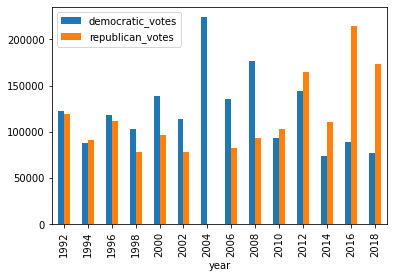

In [28]:
plottable.plot.bar(x='year', y=['democratic_votes', 'republican_votes'])

How do D and R votes relate in on and off years?

In [ ]:
presidents = top_two_by_race[top_two_by_race.year%4==0].copy()
offs = top_two_by_race[top_two_by_race.year%4==2].copy()

In [30]:
offs['pres_year'] = offs.year-2

In [31]:
offset_years = presidents.merge(offs, left_on = ['state', 'district', 'year'], right_on= ['state', 'district', 'pres_year'])

In [32]:
offset_years.columns = ['year_pres', 'state', 'district', 'democratic_candidate_pres',
       'democratic_votes_pres', 'democratic_party_pres', 'republican_candidate_pres',
       'republican_votes_pres', 'republican_party_pres', 'year_off',
       'democratic_candidate_off', 'democratic_votes_off', 'democratic_party_off',
       'republican_candidate_off', 'republican_votes_off', 'republican_party_off',
       'pres_year']

<AxesSubplot:xlabel='democratic_votes_pres', ylabel='democratic_votes_off'>

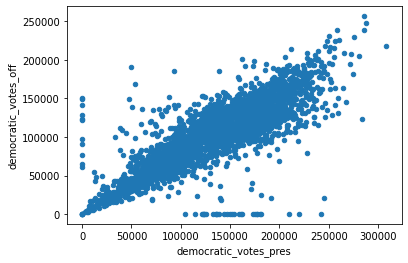

In [33]:
offset_years.plot.scatter(x='democratic_votes_pres', y='democratic_votes_off')

<AxesSubplot:xlabel='republican_votes_pres', ylabel='republican_votes_off'>

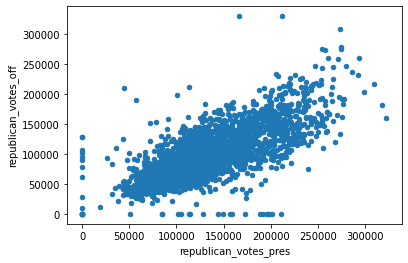

In [34]:
offset_years.plot.scatter(x='republican_votes_pres', y='republican_votes_off')

Making more elaborate plots that get written to files.

In [23]:
import plotly.io as pio
pio.renderers.default='notebook'

In [40]:
data = []
state = 'Louisiana'
state_subset = top_two_by_race[(top_two_by_race.state==state) & (top_two_by_race.year>=2000)]
for district in state_subset.district.unique():
    subset = state_subset[state_subset.district==district]
    trace = go.Scatter3d(
        x=list(subset['year']),
        y=list(subset['district']),
        z=list(subset['democratic_votes']),
        text=list(subset['democratic_candidate']),
        mode='markers',
        name=f'Dem Votes in {state} district {district}',
        marker=dict(
            size=4,
            color='blue',
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=0.8,
            )
        )
    data.append(trace)
    trace = go.Scatter3d(
        x=list(subset['year']),
        y=list(subset['district']),
        z=list(subset['republican_votes']),
        text=list(subset['republican_candidate']),
        mode='markers',
        name=f'Rep Votes in {state} district {district}',
        marker=dict(
            size=4,
            color='red',
            line=dict(
                color='rgba(217, 217, 217, 0.14)',
                width=0.5
            ),
            opacity=0.8,
            )
        )
    data.append(trace)

layout = go.Layout(
        margin=dict(l=0, r=0, b=0, t=0),
        scene = dict(
            aspectmode='cube',
            xaxis = dict(title='Year'),
            yaxis = dict(title='State'),
            zaxis = dict(title='Votes'),),       
        legend=dict(x=-.1, y=1.2)
        )
fig = go.Figure(data=data, layout=layout)
# go.offline.plot(fig, filename='temp.html')
fig.write_html(f'{state}.html')


<AxesSubplot:xlabel='district', ylabel='democratic_votes'>

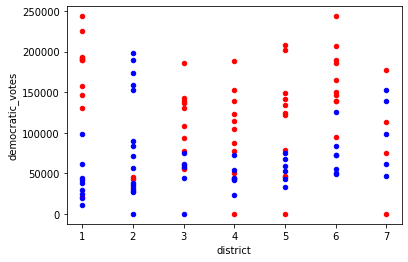

In [41]:
ax = state_subset.plot.scatter(x='district', y='republican_votes', color='red')
state_subset.plot.scatter(x='district', y='democratic_votes', color = 'blue', ax=ax)



In [42]:
# state_subset.plot.scatter(x='district', y='democratic_votes', color = 'blue', ax=ax)

import plotly.graph_objects as go

fig = go.Figure()

fig.add_trace(go.Box(
    y=state_subset.democratic_votes,
    x=state_subset.district,
    name='Dem Votes',
    marker_color='blue'
))

fig.add_trace(go.Box(
    y=state_subset.republican_votes,
    x=state_subset.district,
    name='Rep Votes',
    marker_color='red'
))


fig.update_layout(
    yaxis_title='Votes',
    boxmode='group' # group together boxes of the different traces for each value of x
)
fig.write_html('foo_box.html')